**Hybrid Adversarial Distilled Defense for Deep Learning-Based Breast Cancer Detection.**
Final Script using PGD Adversarial Training

In [1]:
# Library Imports
import os
import copy
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import models, transforms, datasets
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Mount Google Drive for data and model storage
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Constants and Configurations
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
LEARNING_RATE_PATIENCE = 5
EPOCHS_TEACHER = 25
EPOCHS_STUDENT = 50
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Using device: {DEVICE}")

Using device: cuda


In [4]:
# Define the path to save and load models
model_save_path = "/content/drive/MyDrive/Sir Recommendation /"
os.makedirs(model_save_path, exist_ok=True)

In [5]:
# Data Transformations
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [6]:
# Load Datasets from Google Drive
try:
    train_dataset = datasets.ImageFolder('/content/drive/MyDrive/BreakHis_dataset_split/train', transform=train_transforms)
    validation_dataset = datasets.ImageFolder('/content/drive/MyDrive/BreakHis_dataset_split/validation', transform=test_transforms)
    test_dataset = datasets.ImageFolder('/content/drive/MyDrive/BreakHis_dataset_split/test', transform=test_transforms)

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    validation_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

    print("Datasets loaded successfully!")
    print(f"Training samples: {len(train_dataset)}")
    print(f"Validation samples: {len(validation_dataset)}")
    print(f"Test samples: {len(test_dataset)}")

except FileNotFoundError:
    print("Error: Dataset directory not found. Please check the path in your Google Drive.")

Datasets loaded successfully!
Training samples: 7600
Validation samples: 1629
Test samples: 1629


In [7]:
# Student Model Definition
class SimpleStudentModel(nn.Module):
    def __init__(self):
        super(SimpleStudentModel, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, 2)

    def forward(self, x):
        return self.resnet(x)

# Teacher Model Definition
class EnsembleModel(nn.Module):
    def __init__(self):
        super(EnsembleModel, self).__init__()
        self.densenet = models.densenet121(pretrained=True)
        self.resnet = models.resnet50(pretrained=True)
        self.efficientnet = models.efficientnet_b0(pretrained=True)

        # Replace the final layers of each model to output 512-dim features
        self.densenet.classifier = nn.Linear(self.densenet.classifier.in_features, 512)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, 512)
        self.efficientnet.classifier = nn.Sequential(
            nn.Dropout(p=0.2, inplace=True),
            nn.Linear(self.efficientnet.classifier[1].in_features, 512)
        )

        # Final classifier to combine the features from all three models
        self.classifier = nn.Linear(512, 2)

    def forward(self, x):
        # DenseNet feature extraction
        x1 = self.densenet.features(x)
        x1 = F.relu(x1, inplace=True)
        x1 = F.adaptive_avg_pool2d(x1, (1, 1))
        x1 = torch.flatten(x1, 1)
        x1 = self.densenet.classifier(x1)

        # ResNet feature extraction
        x2 = self.resnet.conv1(x)
        x2 = self.resnet.bn1(x2)
        x2 = self.resnet.relu(x2)
        x2 = self.resnet.maxpool(x2)
        x2 = self.resnet.layer1(x2)
        x2 = self.resnet.layer2(x2)
        x2 = self.resnet.layer3(x2)
        x2 = self.resnet.layer4(x2)
        x2 = self.resnet.avgpool(x2)
        x2 = torch.flatten(x2, 1)
        x2 = self.resnet.fc(x2)

        # EfficientNet feature extraction
        x3 = self.efficientnet.features(x)
        x3 = self.efficientnet.avgpool(x3)
        x3 = torch.flatten(x3, 1)
        x3 = self.efficientnet.classifier(x3)

        # Average the features from the three models for the final prediction
        x_avg = (x1 + x2 + x3) / 3.0
        return self.classifier(x_avg)

print("Model classes defined.")

Model classes defined.


In [8]:
# Teacher Model Training Function
def train_teacher(model, train_loader, val_loader, device, epochs, patience, model_path):
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, verbose=True)
    criterion = nn.CrossEntropyLoss()
    model.to(device)

    best_val_acc = 0
    patience_counter = 0

    print("--- Starting Teacher Model Training ---")
    for epoch in range(epochs):
        model.train()
        total_loss = 0.0
        for inputs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1} - Training Loss: {avg_train_loss:.4f}")

        # Validation phase
        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += targets.size(0)
                correct += (predicted == targets).sum().item()

        avg_val_loss = val_loss / len(val_loader)
        val_acc = 100 * correct / total
        print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%")
        scheduler.step(avg_val_loss)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            torch.save(model.state_dict(), model_path)
            print(f"New best teacher model saved with accuracy: {val_acc:.2f}%")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break
    print("--- Finished training teacher model ---")
    model.load_state_dict(torch.load(model_path))
    return model

In [9]:
# Instantiate and train the teacher model (or load if it already exists)
teacher_model = EnsembleModel().to(DEVICE)
teacher_model_path = os.path.join(model_save_path, 'best_teacher_model.pth')

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 129MB/s]
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may 

In [10]:
if os.path.exists(teacher_model_path):
    print("Found existing trained teacher model. Loading it.")
    teacher_model.load_state_dict(torch.load(teacher_model_path))
else:
    print("No trained teacher model found. Starting training now.")
    teacher_model = train_teacher(teacher_model, train_loader, validation_loader, DEVICE, epochs=EPOCHS_TEACHER, patience=5, model_path=teacher_model_path)

Found existing trained teacher model. Loading it.


In [11]:
# Adversarial Attack Functions
def fgsm_attack(model, images, labels, epsilon):
    images.requires_grad = True
    outputs = model(images)
    loss = F.cross_entropy(outputs, labels)
    model.zero_grad()
    loss.backward()
    attack_images = images + epsilon * images.grad.sign()
    return attack_images

def pgd_attack(model, images, labels, epsilon, alpha, iters):
    original_images = images.clone().detach()
    for i in range(iters):
        images.requires_grad = True
        outputs = model(images)
        model.zero_grad()
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        adv_images = images + alpha * images.grad.sign()
        eta = torch.clamp(adv_images - original_images, min=-epsilon, max=epsilon)
        images = torch.clamp(original_images + eta, min=0, max=1).detach()
    return images

In [12]:
# Fgsm Hybrid Distillation Training Function
def hybrid_distillation_training(student_model, teacher_model, train_loader, val_loader, device,
                                 alpha, beta, temperature, epsilon, epochs, patience, model_path):
    optimizer = optim.Adam(student_model.parameters(), lr=0.0005, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, verbose=True)
    kl_loss_fn = nn.KLDivLoss(reduction='batchmean')
    ce_loss_fn = nn.CrossEntropyLoss()

    best_val_loss = float('inf')
    patience_counter = 0

    teacher_model.eval() # Teacher is only for inference

    print("\n--- Starting HYBRID Adversarial Distillation Training for Student ---")
    for epoch in range(epochs):
        student_model.train()
        total_loss = 0.0

        for inputs, targets in tqdm(train_loader, desc=f"Student Epoch {epoch+1}/{epochs}"):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()

            # --- 1. Generate Adversarial Inputs (on the fly) ---
            adv_inputs = fgsm_attack(student_model, inputs.clone().detach(), targets, epsilon).detach()

            # --- 2. Process Clean Inputs ---
            student_clean_outputs = student_model(inputs)
            with torch.no_grad():
                teacher_clean_outputs = teacher_model(inputs)

            ce_loss_clean = ce_loss_fn(student_clean_outputs, targets)
            soft_targets = F.softmax(teacher_clean_outputs / temperature, dim=1)
            soft_preds = F.log_softmax(student_clean_outputs / temperature, dim=1)
            distill_loss = kl_loss_fn(soft_preds, soft_targets) * (temperature ** 2)

            # --- 3. Process Adversarial Inputs ---
            student_adv_outputs = student_model(adv_inputs)
            ce_loss_adv = ce_loss_fn(student_adv_outputs, targets)

            # --- 4. Combine the three loss components ---
            loss = alpha * (ce_loss_clean + distill_loss) + beta * ce_loss_adv

            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)
        print(f"Student Epoch {epoch+1} - Training Loss: {avg_train_loss:.4f}")

        # --- Validation (always on clean data) ---
        student_model.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for val_inputs, val_targets in val_loader:
                val_inputs, val_targets = val_inputs.to(device), val_targets.to(device)
                outputs = student_model(val_inputs)
                loss = ce_loss_fn(outputs, val_targets)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += val_targets.size(0)
                correct += (predicted == val_targets).sum().item()

        avg_val_loss = val_loss / len(val_loader)
        val_acc = 100 * correct / total
        print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_acc:.2f}%")
        scheduler.step(avg_val_loss)

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            torch.save(student_model.state_dict(), model_path)
            print("New best student model saved.")
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered.")
                break

    print("--- Finished student model training ---")
    student_model.load_state_dict(torch.load(model_path))
    return student_model

In [13]:
# Instantiate the student model
student_model = SimpleStudentModel().to(DEVICE)
student_model_path = os.path.join(model_save_path, 'Ep01_best_student_model(resnet18)_hybrid_fgsm.pth')

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 176MB/s]


In [14]:
# Train the student model using the hybrid method
student_model = hybrid_distillation_training(
    student_model=student_model,
    teacher_model=teacher_model,
    train_loader=train_loader,
    val_loader=validation_loader,
    device=DEVICE,
    alpha=0.7, # Weight for clean data loss + distillation loss
    beta=0.3,  # Weight for adversarial loss
    temperature=5.0,
    epsilon=0.1,
    epochs=EPOCHS_STUDENT,
    patience=LEARNING_RATE_PATIENCE,
    model_path=student_model_path
)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



--- Starting HYBRID Adversarial Distillation Training for Student ---


Student Epoch 1/50: 100%|██████████| 238/238 [15:05<00:00,  3.80s/it]

Student Epoch 1 - Training Loss: 3.7805


Validation Loss: 0.5266, Validation Accuracy: 87.48%
New best student model saved.


Student Epoch 2/50: 100%|██████████| 238/238 [02:31<00:00,  1.57it/s]

Student Epoch 2 - Training Loss: 2.8163


Validation Loss: 0.2448, Validation Accuracy: 91.65%
New best student model saved.


Student Epoch 3/50: 100%|██████████| 238/238 [02:31<00:00,  1.57it/s]

Student Epoch 3 - Training Loss: 2.1419


Validation Loss: 0.1897, Validation Accuracy: 93.00%
New best student model saved.


Student Epoch 4/50: 100%|██████████| 238/238 [02:30<00:00,  1.58it/s]

Student Epoch 4 - Training Loss: 1.7835


Validation Loss: 0.1058, Validation Accuracy: 95.83%
New best student model saved.


Student Epoch 5/50: 100%|██████████| 238/238 [02:31<00:00,  1.57it/s]

Student Epoch 5 - Training Loss: 1.5466


Validation Loss: 0.4630, Validation Accuracy: 85.33%


Student Epoch 6/50: 100%|██████████| 238/238 [02:28<00:00,  1.60it/s]

Student Epoch 6 - Training Loss: 1.3743


Validation Loss: 0.1302, Validation Accuracy: 95.83%


Student Epoch 7/50: 100%|██████████| 238/238 [02:27<00:00,  1.61it/s]

Student Epoch 7 - Training Loss: 1.2324


Validation Loss: 0.1366, Validation Accuracy: 94.29%


Student Epoch 8/50: 100%|██████████| 238/238 [02:26<00:00,  1.63it/s]

Student Epoch 8 - Training Loss: 1.1705


Validation Loss: 0.1146, Validation Accuracy: 95.89%


Student Epoch 9/50: 100%|██████████| 238/238 [02:27<00:00,  1.61it/s]

Student Epoch 9 - Training Loss: 0.7756


Validation Loss: 0.2637, Validation Accuracy: 90.18%
Early stopping triggered.
--- Finished student model training ---


In [15]:
# Evaluation Function
def evaluate_model(model, loader, device, epsilon=0, attack_type="none", pgd_alpha=0.01, pgd_iters=10):
    model.eval()
    correct, total = 0, 0
    desc = f"Evaluating (eps={epsilon}, attack={attack_type})"
    for images, labels in tqdm(loader, desc=desc):
        images, labels = images.to(device), labels.to(device)
        if attack_type == "fgsm":
            images = fgsm_attack(model, images.clone(), labels, epsilon)
        elif attack_type == "pgd":
            # For evaluation, a stronger PGD attack is often used
            images = pgd_attack(model, images.clone(), labels, epsilon=epsilon, alpha=pgd_alpha, iters=pgd_iters)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    return 100. * correct / total

In [16]:
# --- Run Final Evaluation ---
print("\n--- Evaluating Final Robust Student Model ---")

# Load the best student model for evaluation
student_model = SimpleStudentModel().to(DEVICE)
student_model.load_state_dict(torch.load(student_model_path))

# Epsilon values for evaluation plot
epsilon_values = [0.01, 0.05, 0.1, 0.2, 0.3]


--- Evaluating Final Robust Student Model ---


In [17]:
# 1. Evaluate on Clean Data
student_clean_acc = evaluate_model(student_model, test_loader, DEVICE)
print(f"\nClean Test Accuracy: {student_clean_acc:.2f}%")

Evaluating (eps=0, attack=none): 100%|██████████| 51/51 [05:25<00:00,  6.38s/it]


Clean Test Accuracy: 96.93%


In [18]:
# 2. Evaluate under FGSM Attack
print("\nEvaluating under FGSM attack...")
student_fgsm_acc = []
for eps in epsilon_values:
    acc = evaluate_model(student_model, test_loader, DEVICE, epsilon=eps, attack_type="fgsm")
    student_fgsm_acc.append(acc)
    print(f"FGSM | Epsilon {eps:.2f}: Accuracy = {acc:.2f}%")


Evaluating under FGSM attack...


Evaluating (eps=0.01, attack=fgsm): 100%|██████████| 51/51 [00:20<00:00,  2.45it/s]


FGSM | Epsilon 0.01: Accuracy = 79.37%


Evaluating (eps=0.05, attack=fgsm): 100%|██████████| 51/51 [00:21<00:00,  2.32it/s]


FGSM | Epsilon 0.05: Accuracy = 38.55%


Evaluating (eps=0.1, attack=fgsm): 100%|██████████| 51/51 [00:21<00:00,  2.33it/s]


FGSM | Epsilon 0.10: Accuracy = 36.89%


Evaluating (eps=0.2, attack=fgsm): 100%|██████████| 51/51 [00:20<00:00,  2.49it/s]


FGSM | Epsilon 0.20: Accuracy = 48.43%


Evaluating (eps=0.3, attack=fgsm): 100%|██████████| 51/51 [00:22<00:00,  2.28it/s]

FGSM | Epsilon 0.30: Accuracy = 63.54%


In [19]:
# 3. Evaluate under PGD Attack
print("\nEvaluating under PGD attack...")
student_pgd_acc = []
for eps in epsilon_values:
    # Using 20 iterations for a reasonably strong PGD evaluation
    acc = evaluate_model(student_model, test_loader, DEVICE, epsilon=eps, attack_type="pgd", pgd_alpha=0.01, pgd_iters=20)
    student_pgd_acc.append(acc)
    print(f"PGD  | Epsilon {eps:.2f}: Accuracy = {acc:.2f}%")


Evaluating under PGD attack...


Evaluating (eps=0.01, attack=pgd): 100%|██████████| 51/51 [01:34<00:00,  1.85s/it]


PGD  | Epsilon 0.01: Accuracy = 34.32%


Evaluating (eps=0.05, attack=pgd): 100%|██████████| 51/51 [01:34<00:00,  1.85s/it]


PGD  | Epsilon 0.05: Accuracy = 3.01%


Evaluating (eps=0.1, attack=pgd): 100%|██████████| 51/51 [01:34<00:00,  1.84s/it]


PGD  | Epsilon 0.10: Accuracy = 0.31%


Evaluating (eps=0.2, attack=pgd): 100%|██████████| 51/51 [01:34<00:00,  1.85s/it]


PGD  | Epsilon 0.20: Accuracy = 0.12%


Evaluating (eps=0.3, attack=pgd): 100%|██████████| 51/51 [01:34<00:00,  1.85s/it]

PGD  | Epsilon 0.30: Accuracy = 0.00%


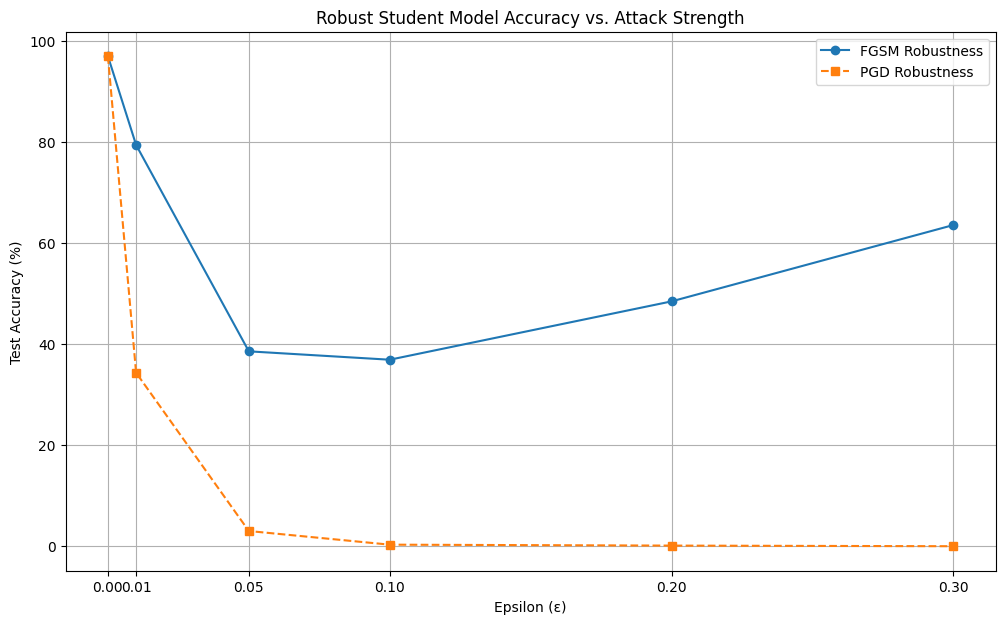

In [20]:
# 4. Plot the results
plt.figure(figsize=(12, 7))
plt.plot([0] + epsilon_values, [student_clean_acc] + student_fgsm_acc, marker='o', linestyle='-', label="FGSM Robustness")
plt.plot([0] + epsilon_values, [student_clean_acc] + student_pgd_acc, marker='s', linestyle='--', label="PGD Robustness")
plt.title("Robust Student Model Accuracy vs. Attack Strength")
plt.xlabel("Epsilon (ε)")
plt.ylabel("Test Accuracy (%)")
plt.xticks([0] + epsilon_values)
plt.legend()
plt.grid(True)
plt.show()